# Session 3.2: Technical Indicators with pandas-ta
## Advanced Technical Analysis for Crypto Trading

### Learning Objectives:
- Master pandas-ta library for technical analysis
- Calculate essential indicators: SMA, EMA, RSI, MACD, Bollinger Bands
- Understand indicator interpretation and signals
- Build multi-timeframe analysis
- Create indicator-based trading signals
- Implement live data technical analysis

### Prerequisites:
- Completed Session 3.1 (Binance API with CCXT)
- Understanding of basic technical analysis concepts

## 1. Setup and Data Preparation

In [24]:
# Import required libraries
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
import ccxt
import os
from datetime import datetime, timedelta
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

print(f"pandas-ta version: {ta.version}")

# Load environment variables
load_dotenv()

pandas-ta version: 0.3.14b0


False

In [25]:
# Robust data fetching function (from Session 3.1)
def get_binance_credentials():
    """Get Binance credentials from environment variables"""
    api_key = os.getenv('BINANCE_API_KEY')
    secret = os.getenv('BINANCE_SECRET_KEY')
    
    if api_key and secret:
        return {'apiKey': api_key, 'secret': secret}
    return {}

def get_crypto_data(symbol='BTC/USDT', timeframe='1h', limit=500):
    """
    Fetch crypto data with robust error handling
    """
    try:
        # Initialize Binance with credentials if available
        config = {
            'enableRateLimit': True,
            'timeout': 30000,
        }
        
        credentials = get_binance_credentials()
        if credentials:
            config.update(credentials)
        
        exchange = ccxt.binance(config)
        
        # Fetch OHLCV data
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
        
        # Convert to DataFrame
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('datetime', inplace=True)
        df.drop('timestamp', axis=1, inplace=True)
        
        # Ensure numeric types
        numeric_cols = ['open', 'high', 'low', 'close', 'volume']
        df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
        
        # Remove any NaN values
        df = df.dropna()
        
        return df
        
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None

# Fetch sample data
print("Fetching BTC/USDT data for analysis...")
btc_data = get_crypto_data('BTC/USDT', '1h', 500)

if btc_data is not None:
    print(f"✓ Data loaded: {len(btc_data)} candles")
    print(f"Date range: {btc_data.index.min()} to {btc_data.index.max()}")
    print("\nData preview:")
    print(btc_data.head())
    print(f"\nData info: No missing values, ready for analysis")
else:
    print("✗ Failed to load data")

Fetching BTC/USDT data for analysis...
✓ Data loaded: 500 candles
Date range: 2025-05-28 23:00:00 to 2025-06-18 18:00:00

Data preview:
                          open       high        low      close     volume
datetime                                                                  
2025-05-28 23:00:00  107400.73  108043.95  107400.73  107781.78  716.28736
2025-05-29 00:00:00  107781.78  108297.87  107421.12  108285.32  732.14610
2025-05-29 01:00:00  108285.31  108347.78  107812.85  108156.23  977.95629
2025-05-29 02:00:00  108156.23  108484.61  107931.15  108426.94  690.46291
2025-05-29 03:00:00  108426.93  108430.76  107955.47  108044.88  611.48079

Data info: No missing values, ready for analysis


## 2. Moving Averages (SMA, EMA)

Moving averages calculated successfully!

Current values (last data point):
close: $104,056.07
SMA_20: $104,748.27
SMA_50: $105,658.22
EMA_12: $104,541.44
EMA_26: $104,825.93
EMA_50: $105,224.05


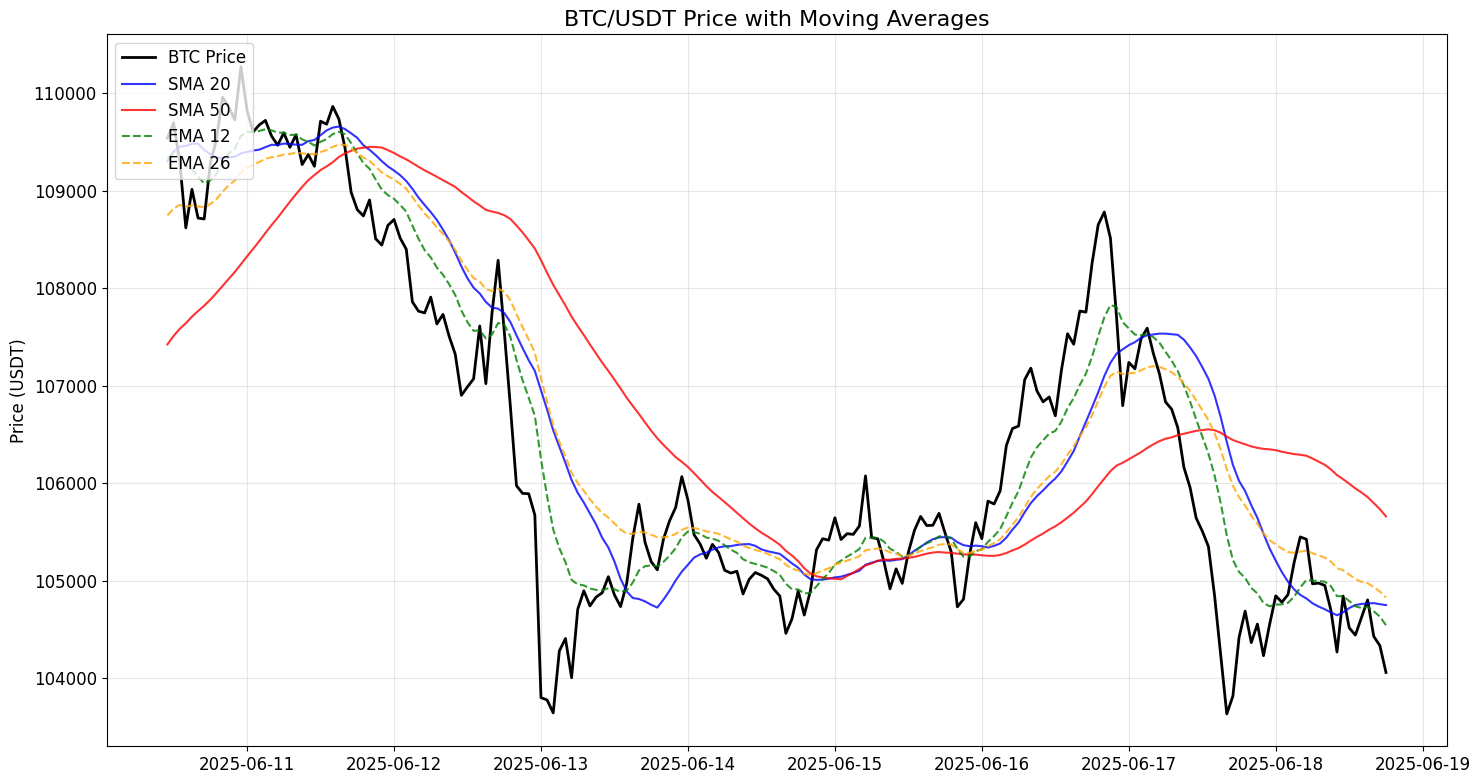


Signal Analysis:
Golden crosses found: 1
Death crosses found: 1

Current Trend Analysis:
Price vs SMA20: Below
Price vs SMA50: Below
SMA20 vs SMA50: Bearish


In [26]:
# Calculate various moving averages
if btc_data is not None:
    # Simple Moving Averages
    btc_data['SMA_20'] = ta.sma(btc_data['close'], length=20)
    btc_data['SMA_50'] = ta.sma(btc_data['close'], length=50)
    btc_data['SMA_200'] = ta.sma(btc_data['close'], length=200)
    
    # Exponential Moving Averages
    btc_data['EMA_12'] = ta.ema(btc_data['close'], length=12)
    btc_data['EMA_26'] = ta.ema(btc_data['close'], length=26)
    btc_data['EMA_50'] = ta.ema(btc_data['close'], length=50)
    
    print("Moving averages calculated successfully!")
    print("\nCurrent values (last data point):")
    current_data = btc_data[['close', 'SMA_20', 'SMA_50', 'EMA_12', 'EMA_26', 'EMA_50']].iloc[-1]
    for col, val in current_data.items():
        if pd.notna(val):
            print(f"{col}: ${val:,.2f}")
    
    # Plot moving averages
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Use last 200 data points for cleaner visualization
    recent_data = btc_data.iloc[-200:]
    
    # Plot price and moving averages
    ax.plot(recent_data.index, recent_data['close'], label='BTC Price', linewidth=2, color='black')
    ax.plot(recent_data.index, recent_data['SMA_20'], label='SMA 20', alpha=0.8, color='blue')
    ax.plot(recent_data.index, recent_data['SMA_50'], label='SMA 50', alpha=0.8, color='red')
    ax.plot(recent_data.index, recent_data['EMA_12'], label='EMA 12', alpha=0.8, linestyle='--', color='green')
    ax.plot(recent_data.index, recent_data['EMA_26'], label='EMA 26', alpha=0.8, linestyle='--', color='orange')
    
    ax.set_title('BTC/USDT Price with Moving Averages', fontsize=16)
    ax.set_ylabel('Price (USDT)', fontsize=12)
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calculate MA signals (only where we have enough data)
    btc_data['golden_cross'] = (
        (btc_data['SMA_50'] > btc_data['SMA_200']) & 
        (btc_data['SMA_50'].shift(1) <= btc_data['SMA_200'].shift(1))
    )
    btc_data['death_cross'] = (
        (btc_data['SMA_50'] < btc_data['SMA_200']) & 
        (btc_data['SMA_50'].shift(1) >= btc_data['SMA_200'].shift(1))
    )
    
    # Count signals
    golden_crosses = btc_data[btc_data['golden_cross'] == True]
    death_crosses = btc_data[btc_data['death_cross'] == True]
    
    print(f"\nSignal Analysis:")
    print(f"Golden crosses found: {len(golden_crosses)}")
    print(f"Death crosses found: {len(death_crosses)}")
    
    # Current trend analysis
    current_price = btc_data['close'].iloc[-1]
    current_sma20 = btc_data['SMA_20'].iloc[-1]
    current_sma50 = btc_data['SMA_50'].iloc[-1]
    
    if pd.notna(current_sma20) and pd.notna(current_sma50):
        print(f"\nCurrent Trend Analysis:")
        print(f"Price vs SMA20: {'Above' if current_price > current_sma20 else 'Below'}")
        print(f"Price vs SMA50: {'Above' if current_price > current_sma50 else 'Below'}")
        print(f"SMA20 vs SMA50: {'Bullish' if current_sma20 > current_sma50 else 'Bearish'}")

## 3. Relative Strength Index (RSI)

RSI Analysis:
Current RSI(14): 38.05
Status: Neutral (30-70) - No clear signal

Recent signals (last 100 periods):
Oversold signals: 4
Overbought signals: 9


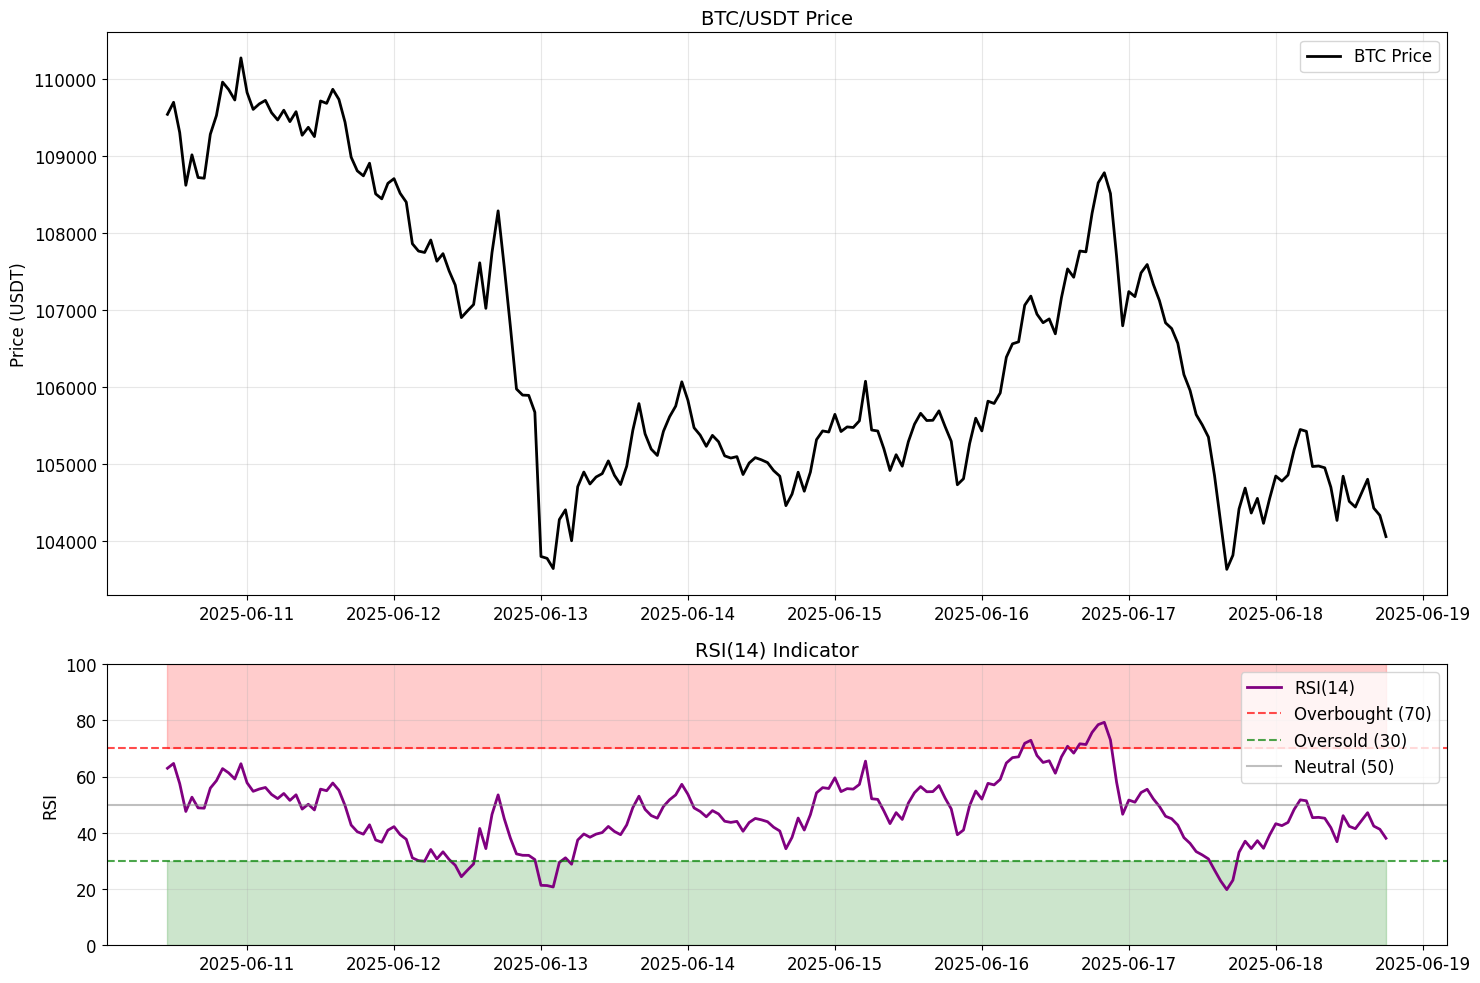


RSI Statistics:
RSI mean: 49.58
RSI standard deviation: 12.10
Time in overbought zone: 5.0%
Time in oversold zone: 4.6%


In [27]:
# Calculate RSI with different periods
if btc_data is not None:
    btc_data['RSI_14'] = ta.rsi(btc_data['close'], length=14)
    btc_data['RSI_21'] = ta.rsi(btc_data['close'], length=21)
    
    # Calculate RSI signals
    btc_data['rsi_oversold'] = btc_data['RSI_14'] < 30
    btc_data['rsi_overbought'] = btc_data['RSI_14'] > 70
    
    # Current RSI analysis
    current_rsi = btc_data['RSI_14'].iloc[-1]
    
    print("RSI Analysis:")
    print(f"Current RSI(14): {current_rsi:.2f}")
    
    if current_rsi > 70:
        print("Status: Overbought (>70) - Potential sell signal")
    elif current_rsi < 30:
        print("Status: Oversold (<30) - Potential buy signal")
    else:
        print("Status: Neutral (30-70) - No clear signal")
    
    # Count signals in recent data
    recent_data = btc_data.iloc[-100:]  # Last 100 periods
    oversold_count = (recent_data['RSI_14'] < 30).sum()
    overbought_count = (recent_data['RSI_14'] > 70).sum()
    
    print(f"\nRecent signals (last 100 periods):")
    print(f"Oversold signals: {oversold_count}")
    print(f"Overbought signals: {overbought_count}")
    
    # Plot RSI
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[2, 1])
    
    # Use recent data for plotting
    recent_data = btc_data.iloc[-200:]
    
    # Price chart
    ax1.plot(recent_data.index, recent_data['close'], label='BTC Price', color='black', linewidth=2)
    ax1.set_title('BTC/USDT Price', fontsize=14)
    ax1.set_ylabel('Price (USDT)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # RSI chart
    ax2.plot(recent_data.index, recent_data['RSI_14'], label='RSI(14)', color='purple', linewidth=2)
    ax2.axhline(y=70, color='red', linestyle='--', alpha=0.7, label='Overbought (70)')
    ax2.axhline(y=30, color='green', linestyle='--', alpha=0.7, label='Oversold (30)')
    ax2.axhline(y=50, color='gray', linestyle='-', alpha=0.5, label='Neutral (50)')
    
    # Highlight overbought/oversold areas
    ax2.fill_between(recent_data.index, 70, 100, alpha=0.2, color='red')
    ax2.fill_between(recent_data.index, 0, 30, alpha=0.2, color='green')
    
    ax2.set_title('RSI(14) Indicator', fontsize=14)
    ax2.set_ylabel('RSI')
    ax2.set_ylim(0, 100)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # RSI statistics
    rsi_mean = btc_data['RSI_14'].mean()
    rsi_std = btc_data['RSI_14'].std()
    time_overbought = (btc_data['RSI_14'] > 70).mean() * 100
    time_oversold = (btc_data['RSI_14'] < 30).mean() * 100
    
    print(f"\nRSI Statistics:")
    print(f"RSI mean: {rsi_mean:.2f}")
    print(f"RSI standard deviation: {rsi_std:.2f}")
    print(f"Time in overbought zone: {time_overbought:.1f}%")
    print(f"Time in oversold zone: {time_oversold:.1f}%")

## 4. MACD (Moving Average Convergence Divergence)

MACD Analysis:
Current MACD: -284.4879
Current Signal: -277.0861
Current Histogram: -7.4018
Status: MACD below signal line (Bearish)
Trend: MACD below zero (Downtrend)

Recent signals (last 100 periods):
MACD bullish crossovers: 4
MACD bearish crossovers: 4


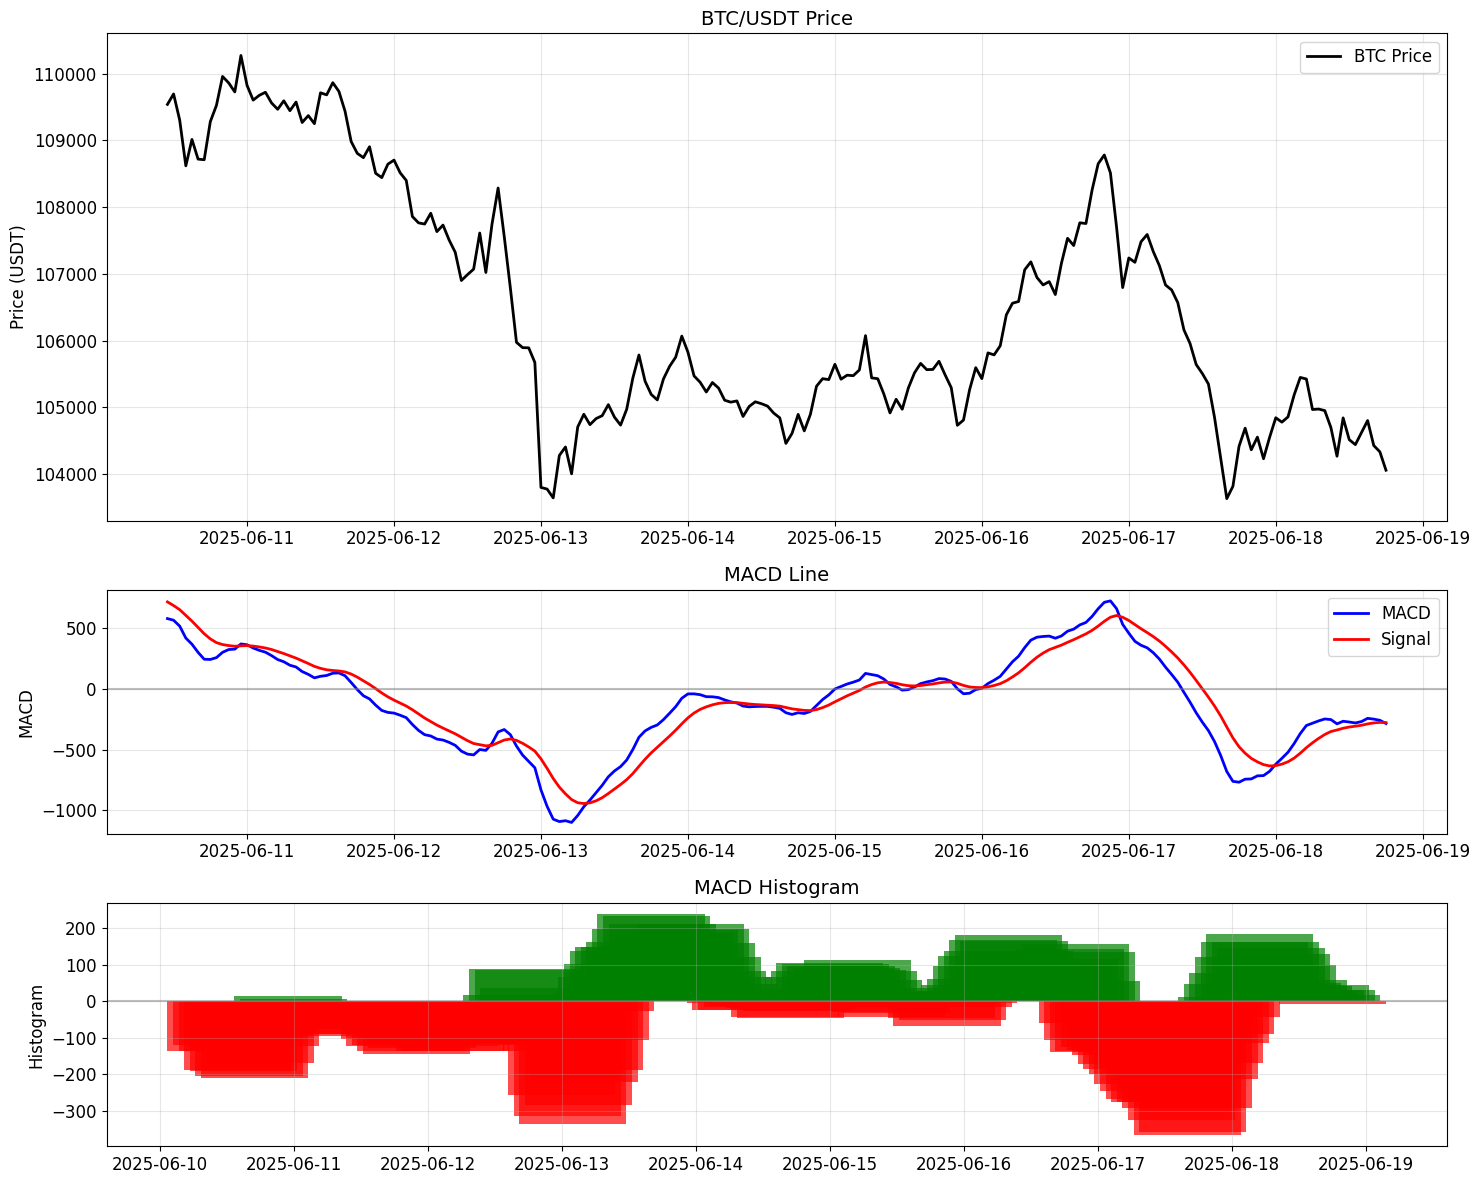


Most recent bullish crossover:
Date: 2025-06-18 00:00:00
Price: $104842.78

Most recent bearish crossover:
Date: 2025-06-18 18:00:00
Price: $104056.07


In [28]:
# Calculate MACD
if btc_data is not None:
    # Calculate MACD with standard parameters (12, 26, 9)
    macd_data = ta.macd(btc_data['close'], fast=12, slow=26, signal=9)
    
    # Extract MACD components
    btc_data['MACD'] = macd_data['MACD_12_26_9']
    btc_data['MACD_signal'] = macd_data['MACDs_12_26_9']
    btc_data['MACD_histogram'] = macd_data['MACDh_12_26_9']
    
    # Calculate MACD signals
    btc_data['macd_bullish_crossover'] = (
        (btc_data['MACD'] > btc_data['MACD_signal']) & 
        (btc_data['MACD'].shift(1) <= btc_data['MACD_signal'].shift(1))
    )
    btc_data['macd_bearish_crossover'] = (
        (btc_data['MACD'] < btc_data['MACD_signal']) & 
        (btc_data['MACD'].shift(1) >= btc_data['MACD_signal'].shift(1))
    )
    
    # Current MACD analysis
    current_macd = btc_data['MACD'].iloc[-1]
    current_signal = btc_data['MACD_signal'].iloc[-1]
    current_histogram = btc_data['MACD_histogram'].iloc[-1]
    
    print("MACD Analysis:")
    print(f"Current MACD: {current_macd:.4f}")
    print(f"Current Signal: {current_signal:.4f}")
    print(f"Current Histogram: {current_histogram:.4f}")
    
    # Interpret current MACD
    if current_macd > current_signal:
        print("Status: MACD above signal line (Bullish)")
    else:
        print("Status: MACD below signal line (Bearish)")
    
    if current_macd > 0:
        print("Trend: MACD above zero (Uptrend)")
    else:
        print("Trend: MACD below zero (Downtrend)")
    
    # Count recent signals
    recent_data = btc_data.iloc[-100:]
    bullish_crossovers = recent_data[recent_data['macd_bullish_crossover'] == True]
    bearish_crossovers = recent_data[recent_data['macd_bearish_crossover'] == True]
    
    print(f"\nRecent signals (last 100 periods):")
    print(f"MACD bullish crossovers: {len(bullish_crossovers)}")
    print(f"MACD bearish crossovers: {len(bearish_crossovers)}")
    
    # Plot MACD
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), height_ratios=[2, 1, 1])
    
    # Use recent data for plotting
    recent_data = btc_data.iloc[-200:]
    
    # Price chart
    ax1.plot(recent_data.index, recent_data['close'], label='BTC Price', color='black', linewidth=2)
    ax1.set_title('BTC/USDT Price', fontsize=14)
    ax1.set_ylabel('Price (USDT)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # MACD line chart
    ax2.plot(recent_data.index, recent_data['MACD'], label='MACD', color='blue', linewidth=2)
    ax2.plot(recent_data.index, recent_data['MACD_signal'], label='Signal', color='red', linewidth=2)
    ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    ax2.set_title('MACD Line', fontsize=14)
    ax2.set_ylabel('MACD')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # MACD histogram
    colors = ['green' if x >= 0 else 'red' for x in recent_data['MACD_histogram']]
    ax3.bar(recent_data.index, recent_data['MACD_histogram'], color=colors, alpha=0.7)
    ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    ax3.set_title('MACD Histogram', fontsize=14)
    ax3.set_ylabel('Histogram')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Show most recent signals
    all_bullish = btc_data[btc_data['macd_bullish_crossover'] == True]
    all_bearish = btc_data[btc_data['macd_bearish_crossover'] == True]
    
    if len(all_bullish) > 0:
        print("\nMost recent bullish crossover:")
        last_bullish = all_bullish.iloc[-1]
        print(f"Date: {last_bullish.name}")
        print(f"Price: ${last_bullish['close']:.2f}")
    
    if len(all_bearish) > 0:
        print("\nMost recent bearish crossover:")
        last_bearish = all_bearish.iloc[-1]
        print(f"Date: {last_bearish.name}")
        print(f"Price: ${last_bearish['close']:.2f}")

## 5. Bollinger Bands

Bollinger Bands Analysis:
Current Price: $104,056.07
Upper Band: $105,455.79
Middle Band: $104,748.27
Lower Band: $104,040.74
Bandwidth: 1.3509
%B: 0.011
Status: Price near lower band (Strong downward pressure)

Recent band touches (last 100 periods):
Upper band touches: 9
Lower band touches: 4


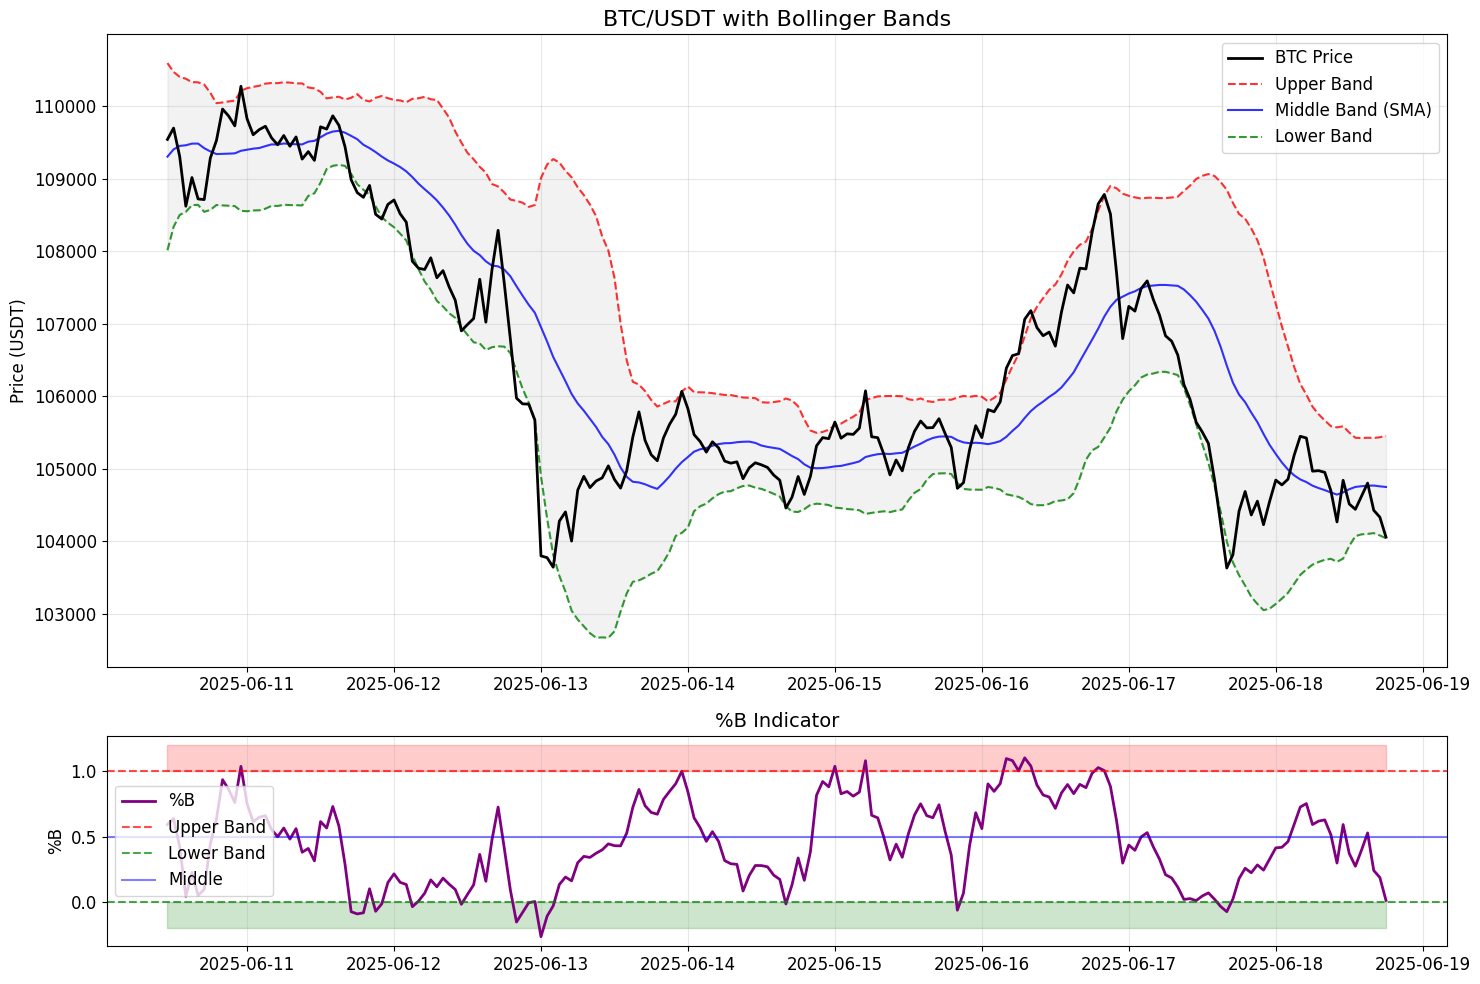


Bollinger Bands Statistics:
Average bandwidth: 2.1993
Current bandwidth percentile: 28.2%
Time above upper band: 6.2%
Time below lower band: 7.0%


In [29]:
# Calculate Bollinger Bands
if btc_data is not None:
    # Calculate Bollinger Bands with standard parameters (20 period, 2 std dev)
    bb_data = ta.bbands(btc_data['close'], length=20, std=2)
    
    btc_data['BB_upper'] = bb_data['BBU_20_2.0']
    btc_data['BB_middle'] = bb_data['BBM_20_2.0']  # This is the SMA
    btc_data['BB_lower'] = bb_data['BBL_20_2.0']
    btc_data['BB_width'] = bb_data['BBB_20_2.0']  # Bandwidth
    btc_data['BB_percent'] = bb_data['BBP_20_2.0']  # %B
    
    # Calculate BB signals
    btc_data['bb_upper_touch'] = btc_data['close'] >= btc_data['BB_upper']
    btc_data['bb_lower_touch'] = btc_data['close'] <= btc_data['BB_lower']
    
    # Current analysis
    current_price = btc_data['close'].iloc[-1]
    current_upper = btc_data['BB_upper'].iloc[-1]
    current_middle = btc_data['BB_middle'].iloc[-1]
    current_lower = btc_data['BB_lower'].iloc[-1]
    current_percent_b = btc_data['BB_percent'].iloc[-1]
    current_width = btc_data['BB_width'].iloc[-1]
    
    print("Bollinger Bands Analysis:")
    print(f"Current Price: ${current_price:,.2f}")
    print(f"Upper Band: ${current_upper:,.2f}")
    print(f"Middle Band: ${current_middle:,.2f}")
    print(f"Lower Band: ${current_lower:,.2f}")
    print(f"Bandwidth: {current_width:.4f}")
    print(f"%B: {current_percent_b:.3f}")
    
    # Interpret %B
    if current_percent_b > 1:
        print("Status: Price above upper band (Potential overbought)")
    elif current_percent_b < 0:
        print("Status: Price below lower band (Potential oversold)")
    elif current_percent_b > 0.8:
        print("Status: Price near upper band (Strong upward pressure)")
    elif current_percent_b < 0.2:
        print("Status: Price near lower band (Strong downward pressure)")
    else:
        print(f"Status: Price within normal range ({current_percent_b*100:.1f}% from lower to upper)")
    
    # Count band touches
    recent_data = btc_data.iloc[-100:]
    upper_touches = (recent_data['close'] >= recent_data['BB_upper']).sum()
    lower_touches = (recent_data['close'] <= recent_data['BB_lower']).sum()
    
    print(f"\nRecent band touches (last 100 periods):")
    print(f"Upper band touches: {upper_touches}")
    print(f"Lower band touches: {lower_touches}")
    
    # Plot Bollinger Bands
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[3, 1])
    
    # Use recent data for plotting
    recent_data = btc_data.iloc[-200:]
    
    # Price and Bollinger Bands
    ax1.plot(recent_data.index, recent_data['close'], label='BTC Price', color='black', linewidth=2, zorder=3)
    ax1.plot(recent_data.index, recent_data['BB_upper'], label='Upper Band', color='red', linestyle='--', alpha=0.8)
    ax1.plot(recent_data.index, recent_data['BB_middle'], label='Middle Band (SMA)', color='blue', alpha=0.8)
    ax1.plot(recent_data.index, recent_data['BB_lower'], label='Lower Band', color='green', linestyle='--', alpha=0.8)
    
    # Fill between bands
    ax1.fill_between(recent_data.index, recent_data['BB_upper'], recent_data['BB_lower'], alpha=0.1, color='gray')
    
    ax1.set_title('BTC/USDT with Bollinger Bands', fontsize=16)
    ax1.set_ylabel('Price (USDT)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # %B indicator
    ax2.plot(recent_data.index, recent_data['BB_percent'], label='%B', color='purple', linewidth=2)
    ax2.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Upper Band')
    ax2.axhline(y=0, color='green', linestyle='--', alpha=0.7, label='Lower Band')
    ax2.axhline(y=0.5, color='blue', linestyle='-', alpha=0.5, label='Middle')
    
    # Highlight extreme zones
    ax2.fill_between(recent_data.index, 1, 1.2, alpha=0.2, color='red')
    ax2.fill_between(recent_data.index, -0.2, 0, alpha=0.2, color='green')
    
    ax2.set_title('%B Indicator', fontsize=14)
    ax2.set_ylabel('%B')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # BB Statistics
    avg_width = btc_data['BB_width'].mean()
    current_width_percentile = (btc_data['BB_width'] <= current_width).mean() * 100
    time_above_upper = (btc_data['BB_percent'] > 1).mean() * 100
    time_below_lower = (btc_data['BB_percent'] < 0).mean() * 100
    
    print(f"\nBollinger Bands Statistics:")
    print(f"Average bandwidth: {avg_width:.4f}")
    print(f"Current bandwidth percentile: {current_width_percentile:.1f}%")
    print(f"Time above upper band: {time_above_upper:.1f}%")
    print(f"Time below lower band: {time_below_lower:.1f}%")
    
    if current_width_percentile < 20:
        print("⚠️  Low volatility - potential breakout ahead")
    elif current_width_percentile > 80:
        print("⚠️  High volatility - bands may contract soon")

## 6. Additional Key Indicators

Additional Indicators Summary:
Stochastic %K: 31.70
Stochastic %D: 40.32
ATR (volatility): 632.69
Current Volume: 215
Average Volume: 549
Stochastic Status: Neutral (20-80)

Volume Analysis:
Volume vs Average: 0.39x
Volume Status: Low volume (<0.5x average)


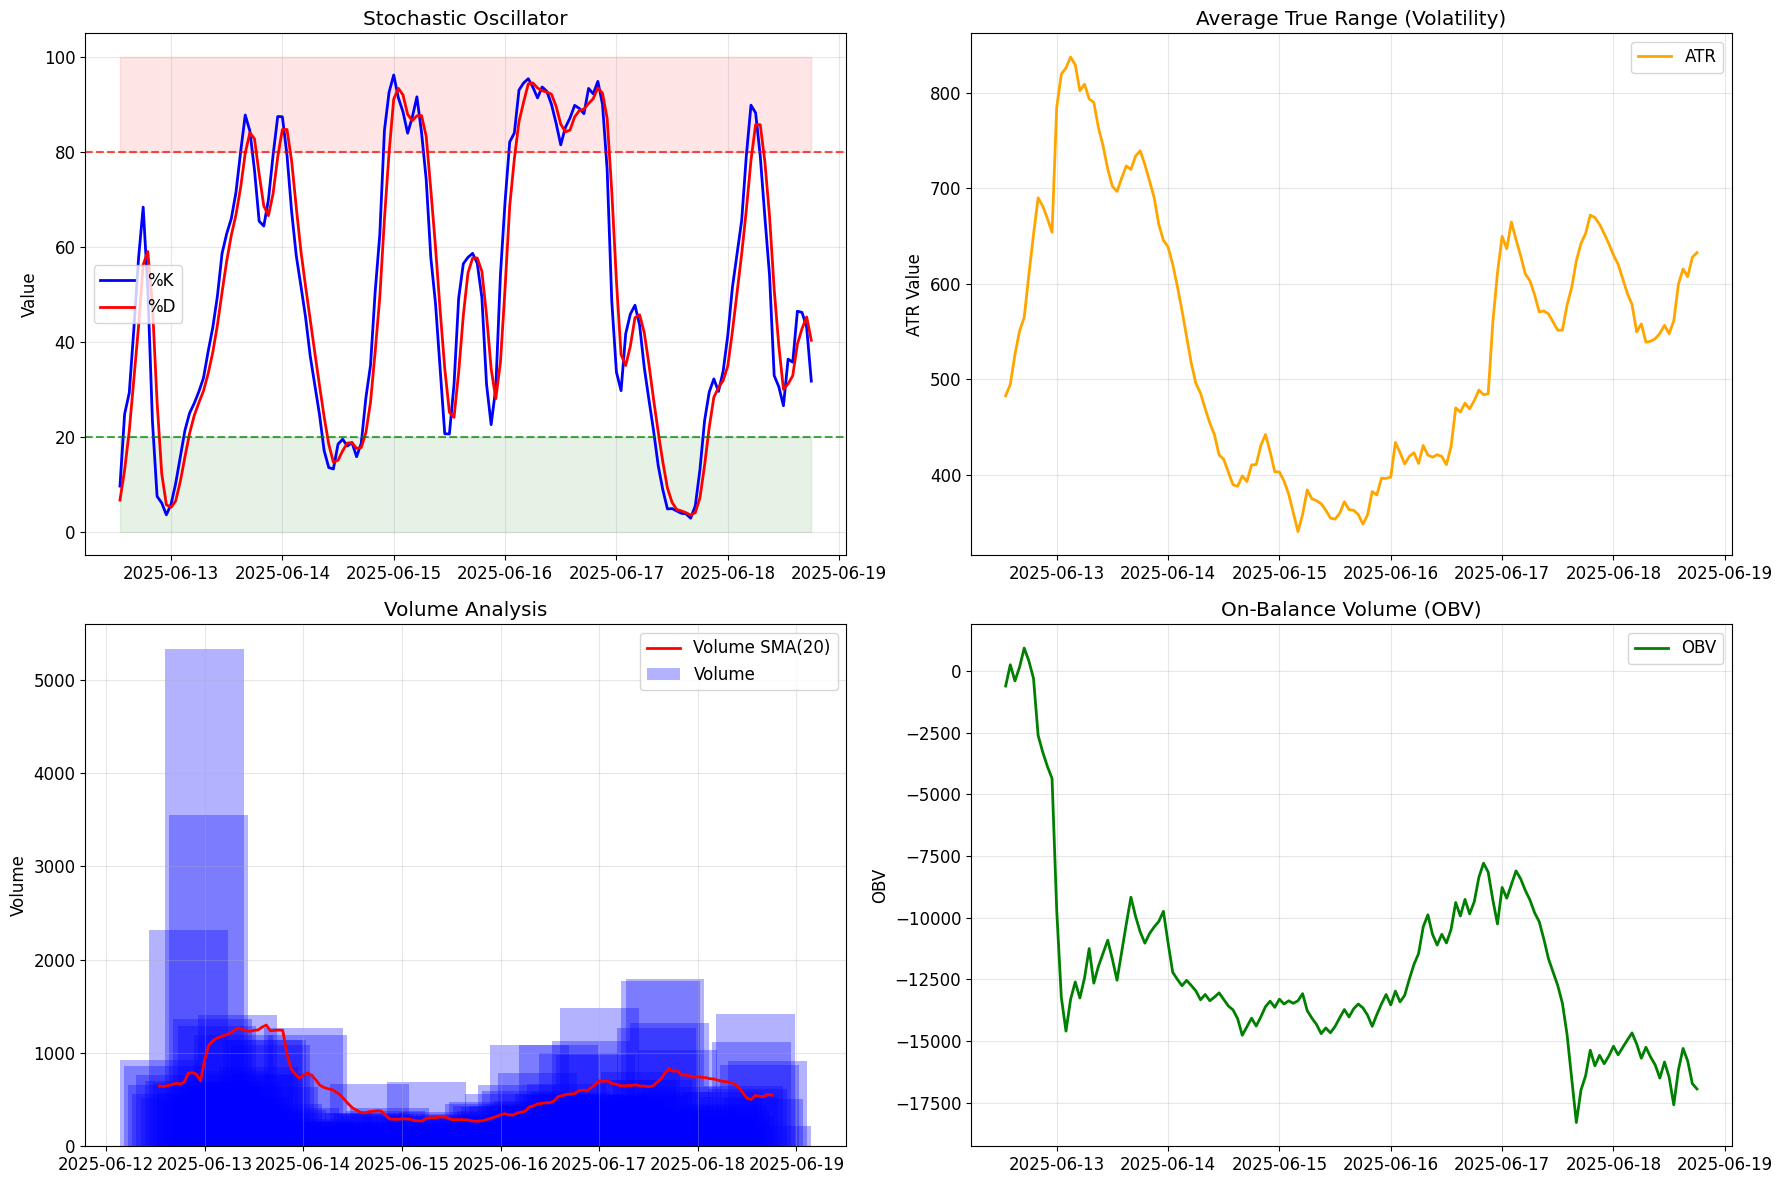

In [30]:
# Calculate additional important technical indicators
if btc_data is not None:
    # Stochastic Oscillator
    stoch_data = ta.stoch(btc_data['high'], btc_data['low'], btc_data['close'], k=14, d=3)
    btc_data['Stoch_K'] = stoch_data['STOCHk_14_3_3']
    btc_data['Stoch_D'] = stoch_data['STOCHd_14_3_3']
    
    # Average True Range (ATR) - for volatility
    btc_data['ATR'] = ta.atr(btc_data['high'], btc_data['low'], btc_data['close'], length=14)
    
    # Volume indicators
    btc_data['Volume_SMA'] = ta.sma(btc_data['volume'], length=20)
    btc_data['OBV'] = ta.obv(btc_data['close'], btc_data['volume'])
    
    # Current values
    current_stoch_k = btc_data['Stoch_K'].iloc[-1]
    current_stoch_d = btc_data['Stoch_D'].iloc[-1]
    current_atr = btc_data['ATR'].iloc[-1]
    current_volume = btc_data['volume'].iloc[-1]
    avg_volume = btc_data['Volume_SMA'].iloc[-1]
    
    print("Additional Indicators Summary:")
    print(f"Stochastic %K: {current_stoch_k:.2f}")
    print(f"Stochastic %D: {current_stoch_d:.2f}")
    print(f"ATR (volatility): {current_atr:.2f}")
    print(f"Current Volume: {current_volume:,.0f}")
    print(f"Average Volume: {avg_volume:,.0f}")
    
    # Interpret Stochastic
    if current_stoch_k > 80:
        print("Stochastic Status: Overbought (>80)")
    elif current_stoch_k < 20:
        print("Stochastic Status: Oversold (<20)")
    else:
        print("Stochastic Status: Neutral (20-80)")
    
    # Volume analysis
    volume_ratio = current_volume / avg_volume if avg_volume > 0 else 0
    print(f"\nVolume Analysis:")
    print(f"Volume vs Average: {volume_ratio:.2f}x")
    if volume_ratio > 1.5:
        print("Volume Status: High volume (>1.5x average)")
    elif volume_ratio < 0.5:
        print("Volume Status: Low volume (<0.5x average)")
    else:
        print("Volume Status: Normal volume")
    
    # Create indicators visualization
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Use recent data
    recent_data = btc_data.iloc[-150:]
    
    # Stochastic
    axes[0,0].plot(recent_data.index, recent_data['Stoch_K'], label='%K', linewidth=2, color='blue')
    axes[0,0].plot(recent_data.index, recent_data['Stoch_D'], label='%D', linewidth=2, color='red')
    axes[0,0].axhline(y=80, color='red', linestyle='--', alpha=0.7)
    axes[0,0].axhline(y=20, color='green', linestyle='--', alpha=0.7)
    axes[0,0].fill_between(recent_data.index, 80, 100, alpha=0.1, color='red')
    axes[0,0].fill_between(recent_data.index, 0, 20, alpha=0.1, color='green')
    axes[0,0].set_title('Stochastic Oscillator')
    axes[0,0].set_ylabel('Value')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # ATR (Average True Range)
    axes[0,1].plot(recent_data.index, recent_data['ATR'], label='ATR', color='orange', linewidth=2)
    axes[0,1].set_title('Average True Range (Volatility)')
    axes[0,1].set_ylabel('ATR Value')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Volume Analysis
    axes[1,0].bar(recent_data.index, recent_data['volume'], alpha=0.3, color='blue', label='Volume')
    axes[1,0].plot(recent_data.index, recent_data['Volume_SMA'], color='red', linewidth=2, label='Volume SMA(20)')
    axes[1,0].set_title('Volume Analysis')
    axes[1,0].set_ylabel('Volume')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # On-Balance Volume (OBV)
    axes[1,1].plot(recent_data.index, recent_data['OBV'], color='green', linewidth=2, label='OBV')
    axes[1,1].set_title('On-Balance Volume (OBV)')
    axes[1,1].set_ylabel('OBV')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 7. Simple Trading Signals

Trading Signals Analysis:
Current signal score: -1
⚪ Neutral - No clear signal

Recent signals (last 100 periods):
Strong buy signals: 0
Strong sell signals: 0


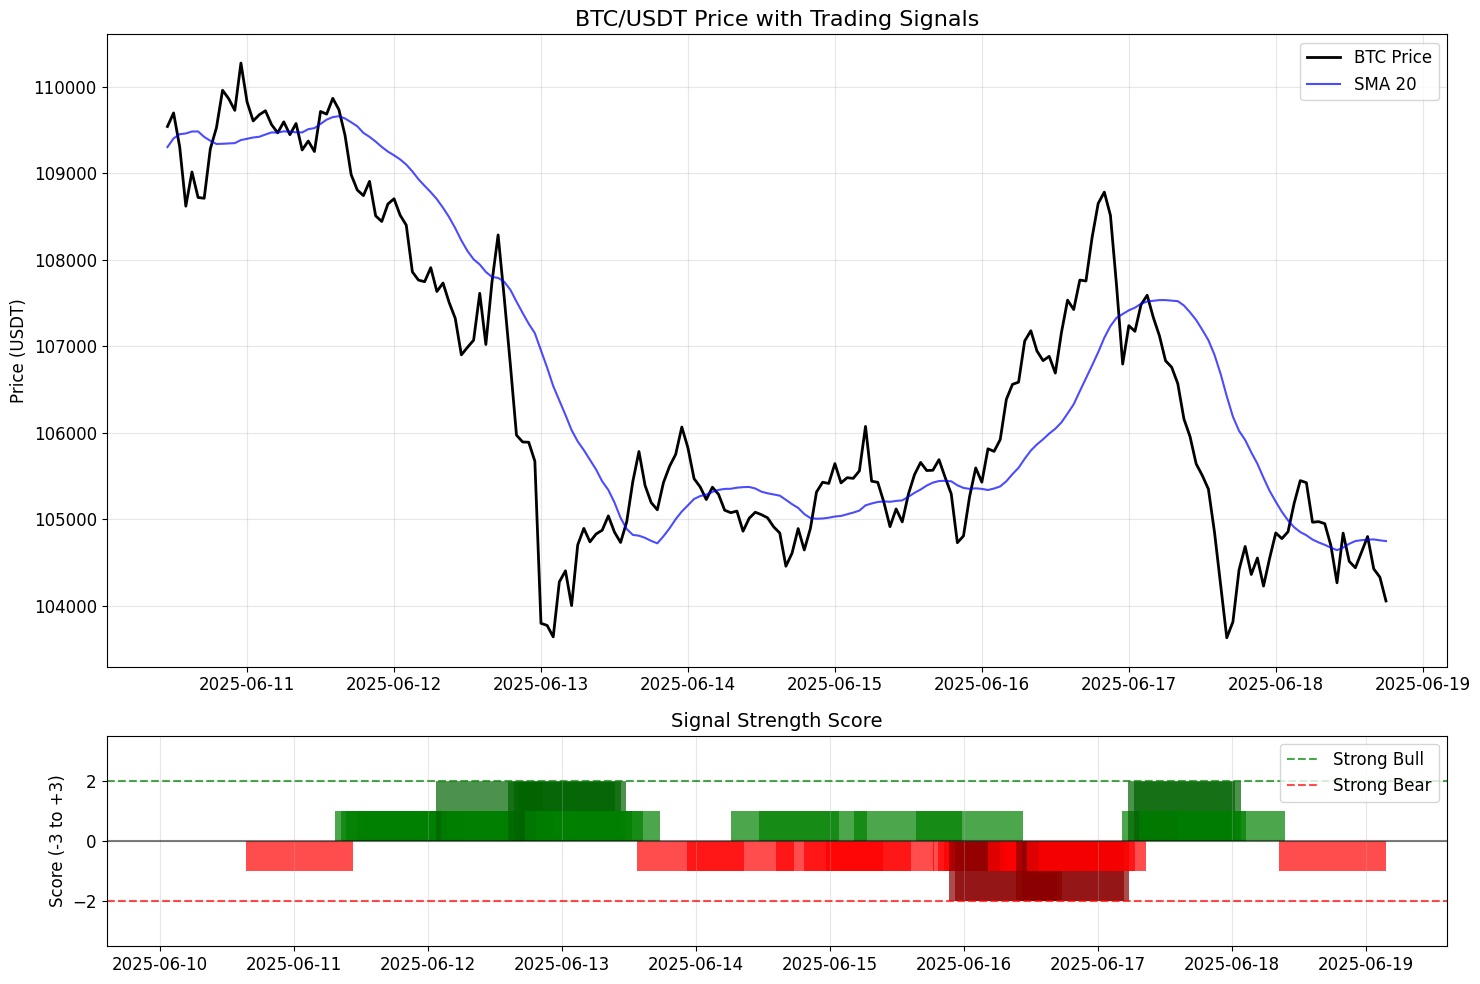


No recent strong signals found


In [31]:
# Create simple but effective trading signals
def generate_simple_signals(data):
    """
    Generate simple trading signals based on multiple indicators
    """
    signals = pd.DataFrame(index=data.index)
    signals['price'] = data['close']
    
    # Individual signals
    signals['rsi_buy'] = data['RSI_14'] < 30  # RSI oversold
    signals['rsi_sell'] = data['RSI_14'] > 70  # RSI overbought
    
    signals['macd_buy'] = (data['MACD'] > data['MACD_signal']) & (data['MACD'].shift(1) <= data['MACD_signal'].shift(1))
    signals['macd_sell'] = (data['MACD'] < data['MACD_signal']) & (data['MACD'].shift(1) >= data['MACD_signal'].shift(1))
    
    signals['bb_buy'] = data['close'] <= data['BB_lower']  # Price touches lower BB
    signals['bb_sell'] = data['close'] >= data['BB_upper']  # Price touches upper BB
    
    signals['trend_bullish'] = data['close'] > data['SMA_20']  # Price above SMA
    signals['trend_bearish'] = data['close'] < data['SMA_20']  # Price below SMA
    
    # Combined signals (require multiple confirmations)
    signals['strong_buy'] = (
        signals['rsi_buy'] & 
        signals['bb_buy'] & 
        signals['trend_bullish']
    )
    
    signals['strong_sell'] = (
        signals['rsi_sell'] & 
        signals['bb_sell'] & 
        signals['trend_bearish']
    )
    
    # Signal strength score (-3 to +3)
    signals['signal_score'] = (
        signals['rsi_buy'].astype(int) +
        signals['macd_buy'].astype(int) +
        signals['bb_buy'].astype(int)
    ) - (
        signals['rsi_sell'].astype(int) +
        signals['macd_sell'].astype(int) +
        signals['bb_sell'].astype(int)
    )
    
    return signals

# Generate signals
if btc_data is not None:
    signals = generate_simple_signals(btc_data)
    
    print("Trading Signals Analysis:")
    print("=" * 30)
    
    # Current signal analysis
    current_score = signals['signal_score'].iloc[-1]
    current_strong_buy = signals['strong_buy'].iloc[-1]
    current_strong_sell = signals['strong_sell'].iloc[-1]
    
    print(f"Current signal score: {current_score}")
    
    if current_strong_buy:
        print("🟢 STRONG BUY SIGNAL - Multiple indicators confirm oversold bounce opportunity")
    elif current_strong_sell:
        print("🔴 STRONG SELL SIGNAL - Multiple indicators confirm overbought condition")
    elif current_score >= 2:
        print("🟡 Bullish signal - Consider buying")
    elif current_score <= -2:
        print("🟡 Bearish signal - Consider selling")
    else:
        print("⚪ Neutral - No clear signal")
    
    # Count signals in recent period
    recent_signals = signals.iloc[-100:]
    strong_buy_count = recent_signals['strong_buy'].sum()
    strong_sell_count = recent_signals['strong_sell'].sum()
    
    print(f"\nRecent signals (last 100 periods):")
    print(f"Strong buy signals: {strong_buy_count}")
    print(f"Strong sell signals: {strong_sell_count}")
    
    # Plot signals
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[3, 1])
    
    # Recent data for plotting
    recent_data = btc_data.iloc[-200:]
    recent_signals = signals.iloc[-200:]
    
    # Price chart with signals
    ax1.plot(recent_data.index, recent_data['close'], label='BTC Price', color='black', linewidth=2)
    ax1.plot(recent_data.index, recent_data['SMA_20'], label='SMA 20', color='blue', alpha=0.7)
    
    # Mark strong signals
    strong_buys = recent_signals[recent_signals['strong_buy']]
    strong_sells = recent_signals[recent_signals['strong_sell']]
    
    if len(strong_buys) > 0:
        ax1.scatter(strong_buys.index, strong_buys['price'], color='green', marker='^', 
                   s=150, label='Strong Buy', zorder=5, edgecolors='darkgreen', linewidth=2)
    
    if len(strong_sells) > 0:
        ax1.scatter(strong_sells.index, strong_sells['price'], color='red', marker='v', 
                   s=150, label='Strong Sell', zorder=5, edgecolors='darkred', linewidth=2)
    
    ax1.set_title('BTC/USDT Price with Trading Signals', fontsize=16)
    ax1.set_ylabel('Price (USDT)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Signal strength over time
    colors = ['darkred' if x <= -2 else 'red' if x < 0 else 'gray' if x == 0 else 'green' if x < 2 else 'darkgreen' 
              for x in recent_signals['signal_score']]
    
    ax2.bar(recent_signals.index, recent_signals['signal_score'], color=colors, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.axhline(y=2, color='green', linestyle='--', alpha=0.7, label='Strong Bull')
    ax2.axhline(y=-2, color='red', linestyle='--', alpha=0.7, label='Strong Bear')
    
    ax2.set_title('Signal Strength Score', fontsize=14)
    ax2.set_ylabel('Score (-3 to +3)')
    ax2.set_ylim(-3.5, 3.5)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Show recent strong signals
    all_strong_signals = signals[(signals['strong_buy']) | (signals['strong_sell'])]
    recent_strong = all_strong_signals.tail(5)
    
    if len(recent_strong) > 0:
        print("\nRecent Strong Signals:")
        print("-" * 25)
        for idx, row in recent_strong.iterrows():
            signal_type = "STRONG BUY" if row['strong_buy'] else "STRONG SELL"
            print(f"{idx.strftime('%Y-%m-%d %H:%M')}: {signal_type} at ${row['price']:,.2f}")
    else:
        print("\nNo recent strong signals found")

## 8. Live Data Technical Analysis

This section demonstrates real-time technical analysis using live market data. It fetches current market data and applies all the indicators we've learned about.

In [35]:
# Live Data Analysis Class
class LiveTechnicalAnalysis:
    def __init__(self, use_credentials=True):
        self.use_credentials = use_credentials
        self.setup_exchange()
    
    def setup_exchange(self):
        """Setup Binance exchange connection"""
        try:
            config = {
                'enableRateLimit': True,
                'timeout': 30000,
            }
            
            if self.use_credentials:
                credentials = get_binance_credentials()
                if credentials:
                    config.update(credentials)
            
            self.exchange = ccxt.binance(config)
            print("✓ Exchange connection established")
            
        except Exception as e:
            print(f"✗ Failed to setup exchange: {e}")
            self.exchange = None
    
    def get_live_data(self, symbol, timeframe='1h', limit=200):
        """Fetch live market data"""
        if not self.exchange:
            print("Exchange not available")
            return None
        
        try:
            ohlcv = self.exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
            
            df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
            df.set_index('datetime', inplace=True)
            df.drop('timestamp', axis=1, inplace=True)
            
            # Ensure numeric types
            numeric_cols = ['open', 'high', 'low', 'close', 'volume']
            df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
            df = df.dropna()
            
            return df
            
        except Exception as e:
            print(f"Error fetching live data: {e}")
            return None
    
    def calculate_all_indicators(self, data):
        """Calculate all technical indicators"""
        # Moving averages
        data['SMA_20'] = ta.sma(data['close'], length=20)
        data['SMA_50'] = ta.sma(data['close'], length=50)
        data['EMA_12'] = ta.ema(data['close'], length=12)
        data['EMA_26'] = ta.ema(data['close'], length=26)
        
        # RSI
        data['RSI_14'] = ta.rsi(data['close'], length=14)
        
        # MACD
        macd_data = ta.macd(data['close'], fast=12, slow=26, signal=9)
        data['MACD'] = macd_data['MACD_12_26_9']
        data['MACD_signal'] = macd_data['MACDs_12_26_9']
        data['MACD_histogram'] = macd_data['MACDh_12_26_9']
        
        # Bollinger Bands
        bb_data = ta.bbands(data['close'], length=20, std=2)
        data['BB_upper'] = bb_data['BBU_20_2.0']
        data['BB_middle'] = bb_data['BBM_20_2.0']
        data['BB_lower'] = bb_data['BBL_20_2.0']
        data['BB_percent'] = bb_data['BBP_20_2.0']
        
        # Stochastic
        stoch_data = ta.stoch(data['high'], data['low'], data['close'], k=14, d=3)
        data['Stoch_K'] = stoch_data['STOCHk_14_3_3']
        data['Stoch_D'] = stoch_data['STOCHd_14_3_3']
        
        # Volume
        data['Volume_SMA'] = ta.sma(data['volume'], length=20)
        
        return data
    
    def analyze_current_conditions(self, data, symbol):
        """Analyze current market conditions"""
        current = data.iloc[-1]
        
        analysis = {
            'symbol': symbol,
            'timestamp': current.name,
            'price': current['close'],
            'indicators': {}
        }
        
        # Price vs Moving Averages
        analysis['indicators']['price_vs_sma20'] = 'Above' if current['close'] > current['SMA_20'] else 'Below'
        analysis['indicators']['price_vs_sma50'] = 'Above' if current['close'] > current['SMA_50'] else 'Below'
        analysis['indicators']['trend'] = 'Bullish' if current['SMA_20'] > current['SMA_50'] else 'Bearish'
        
        # RSI
        rsi = current['RSI_14']
        if rsi > 70:
            rsi_status = 'Overbought'
        elif rsi < 30:
            rsi_status = 'Oversold'
        else:
            rsi_status = 'Neutral'
        analysis['indicators']['rsi'] = {'value': rsi, 'status': rsi_status}
        
        # MACD
        macd_signal = 'Bullish' if current['MACD'] > current['MACD_signal'] else 'Bearish'
        analysis['indicators']['macd'] = {
            'value': current['MACD'],
            'signal': current['MACD_signal'],
            'status': macd_signal
        }
        
        # Bollinger Bands
        bb_percent = current['BB_percent']
        if bb_percent > 1:
            bb_status = 'Above upper band'
        elif bb_percent < 0:
            bb_status = 'Below lower band'
        else:
            bb_status = f'Within bands ({bb_percent:.1%})'
        analysis['indicators']['bollinger'] = {'percent_b': bb_percent, 'status': bb_status}
        
        # Stochastic
        stoch_k = current['Stoch_K']
        if stoch_k > 80:
            stoch_status = 'Overbought'
        elif stoch_k < 20:
            stoch_status = 'Oversold'
        else:
            stoch_status = 'Neutral'
        analysis['indicators']['stochastic'] = {'k': stoch_k, 'status': stoch_status}
        
        # Volume
        volume_ratio = current['volume'] / current['Volume_SMA'] if current['Volume_SMA'] > 0 else 0
        volume_status = 'High' if volume_ratio > 1.5 else 'Low' if volume_ratio < 0.5 else 'Normal'
        analysis['indicators']['volume'] = {'ratio': volume_ratio, 'status': volume_status}
        
        return analysis
    
    def generate_live_signals(self, data):
        """Generate trading signals from live data"""
        current = data.iloc[-1]
        
        # Count bullish and bearish signals
        bullish_signals = 0
        bearish_signals = 0
        
        # RSI signals
        if current['RSI_14'] < 30:
            bullish_signals += 1
        elif current['RSI_14'] > 70:
            bearish_signals += 1
        
        # MACD signal
        if current['MACD'] > current['MACD_signal']:
            bullish_signals += 1
        else:
            bearish_signals += 1
        
        # Bollinger Bands
        if current['BB_percent'] < 0:
            bullish_signals += 1
        elif current['BB_percent'] > 1:
            bearish_signals += 1
        
        # Trend
        if current['close'] > current['SMA_20']:
            bullish_signals += 1
        else:
            bearish_signals += 1
        
        # Stochastic
        if current['Stoch_K'] < 20:
            bullish_signals += 1
        elif current['Stoch_K'] > 80:
            bearish_signals += 1
        
        # Overall signal
        signal_strength = bullish_signals - bearish_signals
        
        if signal_strength >= 3:
            overall_signal = 'STRONG BUY'
        elif signal_strength >= 1:
            overall_signal = 'BUY'
        elif signal_strength <= -3:
            overall_signal = 'STRONG SELL'
        elif signal_strength <= -1:
            overall_signal = 'SELL'
        else:
            overall_signal = 'NEUTRAL'
        
        return {
            'bullish_signals': bullish_signals,
            'bearish_signals': bearish_signals,
            'signal_strength': signal_strength,
            'overall_signal': overall_signal
        }
    
    def run_live_analysis(self, symbols=['BTC/USDT', 'ETH/USDT'], timeframe='1h'):
        """Run complete live analysis for multiple symbols"""
        print(f"🔴 LIVE TECHNICAL ANALYSIS - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print("=" * 60)
        
        results = {}
        
        for symbol in symbols:
            print(f"\n📊 Analyzing {symbol}...")
            
            # Get live data
            data = self.get_live_data(symbol, timeframe, 200)
            if data is None:
                print(f"❌ Failed to get data for {symbol}")
                continue
            
            # Calculate indicators
            data = self.calculate_all_indicators(data)
            
            # Analyze conditions
            analysis = self.analyze_current_conditions(data, symbol)
            
            # Generate signals
            signals = self.generate_live_signals(data)
            
            # Store results
            results[symbol] = {
                'analysis': analysis,
                'signals': signals,
                'data': data
            }
            
            # Print summary
            self.print_symbol_summary(analysis, signals)
        
        return results
    
    def print_symbol_summary(self, analysis, signals):
        """Print formatted summary for a symbol"""
        print(f"\n💰 Price: ${analysis['price']:,.2f}")
        print(f"⏰ Time: {analysis['timestamp'].strftime('%Y-%m-%d %H:%M')}")
        
        print(f"\n📈 Trend Analysis:")
        print(f"  • Price vs SMA20: {analysis['indicators']['price_vs_sma20']}")
        print(f"  • Price vs SMA50: {analysis['indicators']['price_vs_sma50']}")
        print(f"  • Overall Trend: {analysis['indicators']['trend']}")
        
        print(f"\n🎯 Key Indicators:")
        print(f"  • RSI(14): {analysis['indicators']['rsi']['value']:.1f} ({analysis['indicators']['rsi']['status']})")
        print(f"  • MACD: {analysis['indicators']['macd']['status']}")
        print(f"  • Bollinger: {analysis['indicators']['bollinger']['status']}")
        print(f"  • Stochastic: {analysis['indicators']['stochastic']['k']:.1f} ({analysis['indicators']['stochastic']['status']})")
        print(f"  • Volume: {analysis['indicators']['volume']['status']} ({analysis['indicators']['volume']['ratio']:.1f}x avg)")
        
        # Signal summary with emoji
        signal_emoji = {
            'STRONG BUY': '🟢🟢',
            'BUY': '🟢',
            'NEUTRAL': '⚪',
            'SELL': '🔴',
            'STRONG SELL': '🔴🔴'
        }
        
        emoji = signal_emoji.get(signals['overall_signal'], '⚪')
        print(f"\n{emoji} SIGNAL: {signals['overall_signal']}")
        print(f"  • Bullish signals: {signals['bullish_signals']}")
        print(f"  • Bearish signals: {signals['bearish_signals']}")
        print(f"  • Net strength: {signals['signal_strength']:+d}")
        print("-" * 40)


# Initialize live analysis
print("Initializing Live Technical Analysis...")
live_analyzer = LiveTechnicalAnalysis(use_credentials=True)

Initializing Live Technical Analysis...
✓ Exchange connection established


In [36]:
# Run live analysis for multiple symbols
if live_analyzer.exchange:
    # Analyze popular crypto pairs
    symbols_to_analyze = ['BTC/USDT', 'ETH/USDT', 'BNB/USDT']
    
    try:
        results = live_analyzer.run_live_analysis(symbols_to_analyze, timeframe='1h')
        
        # Summary of all signals
        if results:
            print("\n" + "=" * 60)
            print("📋 OVERALL MARKET SUMMARY")
            print("=" * 60)
            
            for symbol, data in results.items():
                signal = data['signals']['overall_signal']
                price = data['analysis']['price']
                strength = data['signals']['signal_strength']
                
                signal_emoji = {
                    'STRONG BUY': '🟢🟢',
                    'BUY': '🟢',
                    'NEUTRAL': '⚪',
                    'SELL': '🔴',
                    'STRONG SELL': '🔴🔴'
                }.get(signal, '⚪')
                
                print(f"{signal_emoji} {symbol}: ${price:,.2f} - {signal} ({strength:+d})")
            
            # Market sentiment
            all_strengths = [data['signals']['signal_strength'] for data in results.values()]
            avg_strength = sum(all_strengths) / len(all_strengths)
            
            print(f"\n📊 Average Signal Strength: {avg_strength:+.1f}")
            
            if avg_strength >= 2:
                print("🔥 Market Sentiment: STRONGLY BULLISH")
            elif avg_strength >= 0.5:
                print("📈 Market Sentiment: BULLISH")
            elif avg_strength <= -2:
                print("❄️  Market Sentiment: STRONGLY BEARISH")
            elif avg_strength <= -0.5:
                print("📉 Market Sentiment: BEARISH")
            else:
                print("😐 Market Sentiment: NEUTRAL")
    
    except Exception as e:
        print(f"Error in live analysis: {e}")
        print("This might be due to API rate limits or connection issues.")
        print("Try running the analysis again in a few moments.")

else:
    print("❌ Live analysis not available - exchange connection failed")
    print("Please check your internet connection and API credentials.")

🔴 LIVE TECHNICAL ANALYSIS - 2025-06-18 20:07:00

📊 Analyzing BTC/USDT...

💰 Price: $104,228.00
⏰ Time: 2025-06-18 18:00

📈 Trend Analysis:
  • Price vs SMA20: Below
  • Price vs SMA50: Below
  • Overall Trend: Bearish

🎯 Key Indicators:
  • RSI(14): 40.0 (Neutral)
  • MACD: Bullish
  • Bollinger: Within bands (11.0%)
  • Stochastic: 34.7 (Neutral)
  • Volume: Low (0.4x avg)

⚪ SIGNAL: NEUTRAL
  • Bullish signals: 1
  • Bearish signals: 1
  • Net strength: +0
----------------------------------------

📊 Analyzing ETH/USDT...

💰 Price: $2,489.79
⏰ Time: 2025-06-18 18:00

📈 Trend Analysis:
  • Price vs SMA20: Below
  • Price vs SMA50: Below
  • Overall Trend: Bearish

🎯 Key Indicators:
  • RSI(14): 40.3 (Neutral)
  • MACD: Bearish
  • Bollinger: Within bands (8.6%)
  • Stochastic: 36.0 (Neutral)
  • Volume: Normal (0.7x avg)

🔴 SIGNAL: SELL
  • Bullish signals: 0
  • Bearish signals: 2
  • Net strength: -2
----------------------------------------

📊 Analyzing BNB/USDT...

💰 Price: $640.89


In [34]:
# Quick live analysis function for single symbol
def quick_analysis(symbol='BTC/USDT', timeframe='1h'):
    """
    Quick analysis function for instant insights
    """
    if not live_analyzer.exchange:
        print("Exchange not available")
        return
    
    print(f"⚡ Quick Analysis: {symbol}")
    print("=" * 30)
    
    try:
        # Get current data
        data = live_analyzer.get_live_data(symbol, timeframe, 100)
        if data is None:
            print("Failed to get data")
            return
        
        # Calculate key indicators
        data = live_analyzer.calculate_all_indicators(data)
        current = data.iloc[-1]
        
        # Display key metrics
        print(f"💰 Current Price: ${current['close']:,.2f}")
        print(f"📊 RSI(14): {current['RSI_14']:.1f}")
        print(f"📈 MACD: {'Bullish' if current['MACD'] > current['MACD_signal'] else 'Bearish'}")
        print(f"🎯 Price vs SMA20: {'Above' if current['close'] > current['SMA_20'] else 'Below'}")
        
        # Quick signal
        signals = live_analyzer.generate_live_signals(data)
        signal_color = {
            'STRONG BUY': '🟢🟢',
            'BUY': '🟢',
            'NEUTRAL': '⚪',
            'SELL': '🔴',
            'STRONG SELL': '🔴🔴'
        }.get(signals['overall_signal'], '⚪')
        
        print(f"\n{signal_color} Signal: {signals['overall_signal']}")
        
    except Exception as e:
        print(f"Error: {e}")

# Run quick analysis
print("\n" + "=" * 50)
print("🚀 QUICK ANALYSIS EXAMPLES")
print("=" * 50)

# Analyze BTC
quick_analysis('BTC/USDT')

print()  # spacing

# Analyze ETH
quick_analysis('ETH/USDT')

print("\n💡 Tip: Run quick_analysis('YOUR_SYMBOL/USDT') for any trading pair!")


🚀 QUICK ANALYSIS EXAMPLES
⚡ Quick Analysis: BTC/USDT
💰 Current Price: $104,081.82
📊 RSI(14): 38.3
📈 MACD: Bearish
🎯 Price vs SMA20: Below

🔴 Signal: SELL

⚡ Quick Analysis: ETH/USDT
💰 Current Price: $2,487.92
📊 RSI(14): 39.9
📈 MACD: Bearish
🎯 Price vs SMA20: Below

🔴 Signal: SELL

💡 Tip: Run quick_analysis('YOUR_SYMBOL/USDT') for any trading pair!


## Summary

### What You've Learned:

**Core Technical Indicators:**
- **Moving Averages**: SMA, EMA for trend identification
- **RSI**: Momentum oscillator for overbought/oversold conditions  
- **MACD**: Trend-following momentum indicator
- **Bollinger Bands**: Volatility and mean reversion signals
- **Additional Indicators**: Stochastic, ATR, Volume analysis

**Advanced Techniques:**
- **Signal Generation**: Combining multiple indicators for stronger signals
- **Live Data Analysis**: Real-time market analysis with current data
- **Market Sentiment**: Analyzing overall market conditions

### Key Takeaways:

1. **No Single Indicator is Perfect**: Always use combinations for better accuracy
2. **Context Matters**: Consider overall trend when interpreting signals
3. **Volume Confirmation**: Volume adds important context to price movements
4. **Live Analysis**: Real-time data provides the most current market insights
5. **Risk Management**: Technical analysis is a tool, not a guarantee

### Live Analysis Features:

- **Real-time Data**: Fetches current market data from Binance
- **Multiple Timeframes**: Analyze on different time horizons
- **Signal Scoring**: Quantitative approach to signal strength
- **Market Sentiment**: Overall market condition assessment
- **Quick Analysis**: Instant insights for any trading pair

### Next Steps:

1. **Practice**: Use the live analysis tools with different symbols
2. **Backtesting**: Test these signals on historical data
3. **Paper Trading**: Practice with virtual money before real trading
4. **Risk Management**: Always use stop-losses and position sizing
5. **Continuous Learning**: Stay updated with market conditions and new indicators

### Remember:
- Technical analysis is **probabilistic**, not predictive
- Always consider **fundamental analysis** alongside technical signals
- **Risk management** is more important than being right
- **Market conditions** can change rapidly - stay flexible

**Happy Trading! 📈🚀**